# settings

## install

In [1]:
# !pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## imports

In [2]:
import os
import random
import re
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA, KernelPCA

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE

import librosa
import librosa.display
import IPython.display as ipd

import tensorflow as tf
import torch

from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import xgboost as xgb
import lightgbm as lgbm
# import catboost as cat
import optuna

In [3]:
# 경로 설정

os.chdir('/content/drive/MyDrive/Colab Notebooks/aichallenge')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/aichallenge'

## GPU

In [4]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found')
    pass
else:
    print(f'GPU found at: {device_name}')

GPU found at: /device:GPU:0


## functions

In [5]:
def fix_random_seed(random_seed):
    """랜덤시드 고정"""
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print('### random_seed fixed ###\n')


def drop_from_origin(origin_df_in, target_df_in, target_cols):
    #// DataFrame) origin_df_in: 원본 데이터프레임
    #// DataFrame) target_df_in: 원본에서 뺄 데이터프레임
    #// list) target_cols: 중복 검사할 column들
    #// 리턴: origin에서 target을 뺀 여집합

    #// origin과 target은 column 리스트가 일치해야 함
    
    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    ret = origin_concat_target.drop_duplicates(subset=target_cols, keep=False)
    ret.reset_index(drop=True, inplace=True)
    
    return ret


def get_gt_from_origin(origin_df_in, target_df_in, target_cols, label_col, id_col):
    #// DataFrame) origin_df_in: 원본 데이터프레임              (column: [label, target_cols])
    #// DataFrame) target_df_in: 원본에서 gt를 찾을 데이터프레임 (column: [id, target_cols])
    #// list) target_cols: 중복 검사할 column들            (X값이 될 column 리스트)
    #// X값은 전부 numeric
    #// string) label_col: y값 column명
    #// string) id_col: id값 column명
    #// returns: DataFrame) 원본에서 X값이 중복인 row들의 id, X, ground truth

    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    origin_df = origin_df.drop_duplicates(subset=target_cols)
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    origin_concat_target.reset_index(drop=True, inplace=True)
    
    flags = origin_concat_target.duplicated(subset=target_cols, keep=False)
    flags = pd.DataFrame(flags, columns=['dupl'])
    origin_concat_target = pd.concat([origin_concat_target, flags],axis=1)
    
    with_gt_id = origin_concat_target[origin_concat_target['dupl']==True]
    with_gt_id.reset_index(drop=True, inplace=True)
    
    print(with_gt_id.shape)
    cut = len(with_gt_id) / 2

    with_gt = with_gt_id.iloc[:int(cut),:]
    with_id = with_gt_id.iloc[int(cut):,:]

    if len(with_gt) != len(with_id): 
        print("length error")
        return 0
    
    with_gt['std'] = with_gt[target_cols].std(axis=1)
    with_id['std'] = with_id[target_cols].std(axis=1)

    if with_gt['std'].nunique() != with_id['std'].nunique(): 
        print("uniqueness error")
        return 0
    
    with_gt = with_gt.sort_values(by=with_gt.columns[-1])
    with_id = with_id.sort_values(by=with_id.columns[-1])
    
    with_gt.reset_index(drop=True, inplace=True)
    with_id.reset_index(drop=True, inplace=True)
    
    with_id[label_col] = with_gt[label_col]
    
    with_id = with_id.drop(['dupl', 'std'], axis=1)

    id = with_id[id_col]
    X_dupl = with_id[target_cols]
    gt = with_id[label_col] 
    ret = pd.concat([id, X_dupl, gt], axis=1)
    ret.reset_index(drop=True, inplace=True)
    return ret


def inverse_spectral_density(in_df, hz_cols, label_col):
    """푸리에 변환된 spectral density를 역으로 wave 데이터로 변환"""
    #// hz_cols: 주파수 column 이름 리스트  (X값)
    #// label_col: 클래스 column 이름       (y값)
    #// in_df: 원본 pandas dataframe

    spectral_df = in_df.copy()
    
    spectral_df_freq = spectral_df[hz_cols]
    spectral_df_label = spectral_df[label_col]
    
    freq_array = [int(re.sub(r'[^0-9]', '', x)) for x in spectral_df_freq.columns]
    freq_array = np.array(freq_array)
    
    ret = []
    t = []
    for i in range(len(spectral_df)):
        amplitude = spectral_df_freq.iloc[i].values
        Zxx = np.array([freq_array, amplitude]).T
        t, x = signal.istft(Zxx)
        ret.append(x)
    ret = np.asarray(ret)
    ret = pd.DataFrame(ret, columns=t)
    
    return ret, spectral_df_label

def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b--', label='train_loss')
    ax1.plot(epochs, val_loss, 'r:', label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, 'b--', label='train_acc')
    ax2.plot(epochs, val_acc, 'r:', label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid()
    ax2.legend()

    plt.show()

def evaluate_macroF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)), -1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

## read / sort / split

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')
aihub = pd.read_csv('./data/aihub.csv')

cols = [x for x in train.columns if 'HZ' in x]
cols_hz = [int(x[:-2]) for x in cols]

# aihub 데이터에서 test 데이터의 레이블 찾아서 dataframe으로 반환
public = get_gt_from_origin(aihub, test, cols, 'leaktype', 'id')

print('### check shape ###')
train.shape, test.shape, sub.shape, aihub.shape, public.shape

(15640, 541)
### check shape ###


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((33600, 514), (7820, 514), (7820, 2), (78204, 539), (7820, 515))

In [7]:
# submission과 test의 input data 순서 동일하게 맞춰 줌

sorter = list(sub['id'])

test.set_index('id', inplace=True)
public.set_index('id', inplace=True)

test = test.loc[sorter].reset_index()
public = public.loc[sorter].reset_index()

print('### check sorted ###\n')
print(f'sub:  {sub["id"].values[:5]}')
print(f'test: {test["id"].values[:5]}')
print(f'public:  {public["id"].values[:5]}')

### check sorted ###

sub:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
test: ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
public:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']


In [8]:
X_train = train[cols]
y_train = train['leaktype']

X_test = test[cols]
y_test = public['leaktype']

print('### check shape ###')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

### check shape ###


((33600, 513), (33600,), (7820, 513), (7820,))

## config

In [9]:
# 랜덤시드 고정
seed = 42
fix_random_seed(random_seed=seed)

# encdoer / decoder
encoder = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}
decoder = {v: k for k, v in encoder.items()}

# aihub 데이터 비율
aihub_ratio = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}

# lgbm params
early_stopping_rounds = 50
lgbm_params = {'n_estimators': 2000, 'learning_rate': 0.1, 'feature_fraction': 0.5, 
               'bagging_fraction': 0.67, 'bagging_freq': 1, 'verbose': 0, 
               'n_jobs': 6, 'random_state': seed, 'num_class': 5}

# DL params
optimizer = optimizers.Adamax()
loss = 'categorical_crossentropy'
batch_size = 128
epochs = 50
validation_split = 0.1
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

### random_seed fixed ###



# Preprocess

In [10]:
y_train = y_train.replace(encoder)
y_test = y_test.replace(encoder)

y_train.unique(), y_test.unique()

(array([0, 1, 2, 4, 3]), array([2, 0, 1, 3, 4]))

## Oversample

In [11]:
smote = SMOTE(random_state=seed)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

((90000, 513), (90000,))

# train(PCA)

In [12]:
pca = PCA(n_components=40, random_state=seed)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape, X_test_pca.shape

((90000, 40), (7820, 40))

In [13]:
X_train_pca, X_valid_pca, y_train_pca, y_valid_pca = train_test_split(X_train_pca, y_train,
                                                                      test_size=0.2, random_state=seed,
                                                                      shuffle=True, stratify=y_train)

X_train_pca.shape, X_valid_pca.shape, y_train_pca.shape, y_valid_pca.shape

((72000, 40), (18000, 40), (72000,), (18000,))

In [14]:
history_pca = dict()
model_pca = lgbm.LGBMClassifier(**lgbm_params)

model_pca.fit(X_train_pca, y_train_pca,
              eval_set=[(X_train_pca, y_train_pca), (X_valid_pca, y_valid_pca)],
              eval_metric=evaluate_macroF1_lgb,
              early_stopping_rounds=early_stopping_rounds,
              verbose=1,
              callbacks=[lgbm.callback.record_evaluation(history_pca)])

[1]	training's multi_logloss: 1.53545	training's macroF1: 0.573004	valid_1's multi_logloss: 1.53761	valid_1's macroF1: 0.558964
Training until validation scores don't improve for 50 rounds.
[2]	training's multi_logloss: 1.47276	training's macroF1: 0.616256	valid_1's multi_logloss: 1.47713	valid_1's macroF1: 0.597423
[3]	training's multi_logloss: 1.41819	training's macroF1: 0.637644	valid_1's multi_logloss: 1.42477	valid_1's macroF1: 0.62162
[4]	training's multi_logloss: 1.36999	training's macroF1: 0.656754	valid_1's multi_logloss: 1.3783	valid_1's macroF1: 0.632844
[5]	training's multi_logloss: 1.32467	training's macroF1: 0.667865	valid_1's multi_logloss: 1.33486	valid_1's macroF1: 0.645133
[6]	training's multi_logloss: 1.28641	training's macroF1: 0.679715	valid_1's multi_logloss: 1.29816	valid_1's macroF1: 0.658592
[7]	training's multi_logloss: 1.24835	training's macroF1: 0.688921	valid_1's multi_logloss: 1.26133	valid_1's macroF1: 0.671257
[8]	training's multi_logloss: 1.21431	traini

LGBMClassifier(bagging_fraction=0.67, bagging_freq=1, feature_fraction=0.5,
               n_estimators=2000, n_jobs=6, num_class=5, random_state=42,
               verbose=0)

              precision    recall  f1-score   support

         out       0.92      0.75      0.83      2192
          in       0.86      0.73      0.79      1659
      normal       0.93      0.97      0.95      2462
       noise       0.65      0.91      0.76       629
       other       0.69      0.92      0.79       878

    accuracy                           0.85      7820
   macro avg       0.81      0.86      0.82      7820
weighted avg       0.86      0.85      0.85      7820


### Estimated Public F1 : 0.8220614957947427 ###



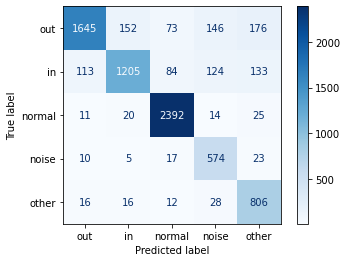

In [15]:
y_pred_pca = model_pca.predict(X_test_pca)

f1 = f1_score(y_test, y_pred_pca, average='macro')

print(classification_report(y_test, y_pred_pca, target_names=encoder.keys()))
print(f'\n### Estimated Public F1 : {f1} ###\n')

cf = confusion_matrix(y_test, y_pred_pca, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca, cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

# train(slice)

In [16]:
X_train

,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,0,2,2,0,2,0,2,2,2,2,...,2,5,2,2,5,2,2,5,2,5
1,0,0,0,3,0,3,0,0,0,0,...,0,3,3,3,3,3,3,3,3,6
2,0,4,4,4,4,5,4,4,5,5,...,5,5,6,5,6,6,6,5,6,4
3,0,6,5,5,6,5,6,6,5,5,...,6,6,7,7,5,6,5,5,7,7
4,0,3,0,0,3,0,0,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,2,3,4,2,4,2,4,4,4,...,5,6,5,6,6,4,5,4,4,4
89996,0,5,5,5,5,5,5,5,7,7,...,5,5,5,5,5,5,6,5,5,5
89997,0,8,8,9,10,8,9,9,8,9,...,9,9,8,8,8,9,9,9,9,8
89998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train_left = X_train[cols[:100]]
X_test_left = X_test[cols[:100]]

In [18]:
X_train_left

,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,...,900HZ,910HZ,920HZ,930HZ,940HZ,950HZ,960HZ,970HZ,980HZ,990HZ
0,0,2,2,0,2,0,2,2,2,2,...,2,2,2,5,2,2,2,2,2,5
1,0,0,0,3,0,3,0,0,0,0,...,3,3,3,0,0,3,0,0,3,3
2,0,4,4,4,4,5,4,4,5,5,...,5,6,5,6,6,5,6,5,5,7
3,0,6,5,5,6,5,6,6,5,5,...,4,4,5,4,5,5,4,5,5,4
4,0,3,0,0,3,0,0,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,2,3,4,2,4,2,4,4,4,...,5,5,5,4,4,4,4,5,4,4
89996,0,5,5,5,5,5,5,5,7,7,...,6,6,7,5,7,7,8,7,7,5
89997,0,8,8,9,10,8,9,9,8,9,...,11,10,12,10,11,11,12,11,11,13
89998,0,0,0,0,0,0,0,0,0,0,...,19,10,10,4,4,4,2,0,0,0


In [19]:
pca = PCA(n_components=40, random_state=seed)

pca.fit(X_train[cols[100:]])

X_train_left_pca = pca.transform(X_train[cols[100:]])
X_test_left_pca = pca.transform(X_test[cols[100:]])

X_train_left_pca = pd.DataFrame(X_train_left_pca)
X_test_left_pca = pd.DataFrame(X_test_left_pca)

In [20]:
X_train_left_pca

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-90.385411,-13.000991,2.463634,6.993298,8.020160,-26.276329,10.074824,4.703589,-6.139976,-1.988547,...,0.941415,-1.203803,2.077382,0.553994,0.873717,0.527165,-2.174051,1.134654,0.184657,0.775225
1,-87.909546,-8.062687,5.763935,10.088420,-22.833154,57.601581,-51.019732,-31.582139,26.492937,-15.271036,...,11.653097,-9.721871,4.772943,11.751982,3.902711,-3.878296,3.845308,11.834445,3.341404,-11.844586
2,-38.320856,-11.673696,6.687107,2.541706,3.549361,-16.932011,6.972324,5.251515,-6.146513,-2.664789,...,-1.161139,-0.646374,-0.456500,-0.953134,0.229272,-0.652008,-2.689421,-0.487475,-1.392114,1.424593
3,164.157304,347.183719,-26.208725,154.294449,-58.449547,-110.046214,15.173822,34.942833,75.413496,-27.346932,...,-14.446934,15.450454,-30.563428,-17.370882,-29.630385,22.835618,-1.338906,12.297085,-10.864461,-16.882759
4,-91.023981,-10.688218,1.231324,9.039143,10.008166,-25.711479,10.549751,6.453083,-6.352793,-2.200306,...,-0.059205,0.349261,0.703139,0.278178,0.067364,-0.672526,0.253526,0.235815,-0.435685,-1.744072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,-32.033100,33.339488,-22.694076,14.525819,-6.158099,-35.211111,-3.432017,27.768201,-13.855780,16.996852,...,3.032682,-3.556263,11.581258,6.129534,12.175972,-6.058660,5.667951,3.193466,-0.453193,11.432755
89996,-32.621741,0.266596,3.914989,-10.545621,-14.213878,37.737650,-2.808069,-5.347441,5.962787,-11.278889,...,-4.703669,3.224880,-1.001278,-1.467242,0.116060,5.187138,-1.938214,-6.613389,-0.456661,3.922635
89997,582.062310,587.378838,531.193392,-125.651818,545.106546,96.908240,8.151521,-153.607155,-157.944322,-155.763499,...,-8.897887,4.823145,-22.461559,31.148696,-26.789027,32.479069,5.420800,4.865310,-15.065674,-13.655362
89998,-139.564553,-17.023048,1.321594,18.697108,13.039782,-32.547240,9.533417,11.567445,-5.253416,-6.343021,...,-0.950711,0.117610,-0.716843,8.367873,0.265238,0.684469,-3.470729,-4.264864,-3.593351,6.547921


In [21]:
X_train_slice = pd.concat([X_train_left, X_train_left_pca], axis=1)
X_test_slice = pd.concat([X_test_left, X_test_left_pca], axis=1)

In [22]:
X_train_slice

,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,90HZ,...,30,31,32,33,34,35,36,37,38,39
0,0,2,2,0,2,0,2,2,2,2,...,0.941415,-1.203803,2.077382,0.553994,0.873717,0.527165,-2.174051,1.134654,0.184657,0.775225
1,0,0,0,3,0,3,0,0,0,0,...,11.653097,-9.721871,4.772943,11.751982,3.902711,-3.878296,3.845308,11.834445,3.341404,-11.844586
2,0,4,4,4,4,5,4,4,5,5,...,-1.161139,-0.646374,-0.456500,-0.953134,0.229272,-0.652008,-2.689421,-0.487475,-1.392114,1.424593
3,0,6,5,5,6,5,6,6,5,5,...,-14.446934,15.450454,-30.563428,-17.370882,-29.630385,22.835618,-1.338906,12.297085,-10.864461,-16.882759
4,0,3,0,0,3,0,0,3,3,3,...,-0.059205,0.349261,0.703139,0.278178,0.067364,-0.672526,0.253526,0.235815,-0.435685,-1.744072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,2,3,4,2,4,2,4,4,4,...,3.032682,-3.556263,11.581258,6.129534,12.175972,-6.058660,5.667951,3.193466,-0.453193,11.432755
89996,0,5,5,5,5,5,5,5,7,7,...,-4.703669,3.224880,-1.001278,-1.467242,0.116060,5.187138,-1.938214,-6.613389,-0.456661,3.922635
89997,0,8,8,9,10,8,9,9,8,9,...,-8.897887,4.823145,-22.461559,31.148696,-26.789027,32.479069,5.420800,4.865310,-15.065674,-13.655362
89998,0,0,0,0,0,0,0,0,0,0,...,-0.950711,0.117610,-0.716843,8.367873,0.265238,0.684469,-3.470729,-4.264864,-3.593351,6.547921


In [23]:
X_train_slice, X_valid_slice, y_train_slice, y_valid_slice = train_test_split(X_train_slice, y_train,
                                                                      test_size=0.2, random_state=seed,
                                                                      shuffle=True, stratify=y_train)

X_train_slice.shape, X_valid_slice.shape, y_train_slice.shape, y_valid_slice.shape

((72000, 140), (18000, 140), (72000,), (18000,))

In [24]:
history_slice = dict()
model_slice = lgbm.LGBMClassifier(**lgbm_params)

model_slice.fit(X_train_slice, y_train_slice,
                eval_set=[(X_train_slice, y_train_slice), (X_valid_slice, y_valid_slice)],
                eval_metric=evaluate_macroF1_lgb,
                early_stopping_rounds=early_stopping_rounds,
                verbose=1,
                callbacks=[lgbm.callback.record_evaluation(history_slice)])

[1]	training's multi_logloss: 1.53657	training's macroF1: 0.576309	valid_1's multi_logloss: 1.53907	valid_1's macroF1: 0.562166
Training until validation scores don't improve for 50 rounds.
[2]	training's multi_logloss: 1.47347	training's macroF1: 0.62842	valid_1's multi_logloss: 1.47803	valid_1's macroF1: 0.610722
[3]	training's multi_logloss: 1.41624	training's macroF1: 0.655851	valid_1's multi_logloss: 1.42324	valid_1's macroF1: 0.642665
[4]	training's multi_logloss: 1.36769	training's macroF1: 0.670292	valid_1's multi_logloss: 1.37642	valid_1's macroF1: 0.655932
[5]	training's multi_logloss: 1.32308	training's macroF1: 0.68218	valid_1's multi_logloss: 1.33334	valid_1's macroF1: 0.67115
[6]	training's multi_logloss: 1.28227	training's macroF1: 0.691789	valid_1's multi_logloss: 1.29369	valid_1's macroF1: 0.678141
[7]	training's multi_logloss: 1.24422	training's macroF1: 0.697721	valid_1's multi_logloss: 1.25726	valid_1's macroF1: 0.686348
[8]	training's multi_logloss: 1.20967	trainin

LGBMClassifier(bagging_fraction=0.67, bagging_freq=1, feature_fraction=0.5,
               n_estimators=2000, n_jobs=6, num_class=5, random_state=42,
               verbose=0)

              precision    recall  f1-score   support

         out       0.92      0.78      0.84      2192
          in       0.90      0.76      0.82      1659
      normal       0.94      0.98      0.96      2462
       noise       0.68      0.93      0.79       629
       other       0.73      0.92      0.81       878

    accuracy                           0.87      7820
   macro avg       0.83      0.88      0.85      7820
weighted avg       0.88      0.87      0.87      7820


### Estimated Public F1 : 0.8456958260432058 ###



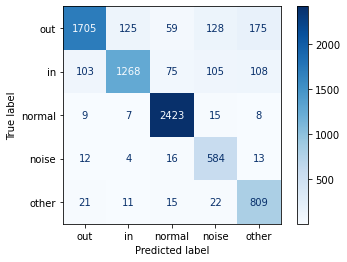

In [26]:
y_pred_slice = model_slice.predict(X_test_slice)

f1 = f1_score(y_test, y_pred_slice, average='macro')

print(classification_report(y_test, y_pred_slice, target_names=encoder.keys()))
print(f'\n### Estimated Public F1 : {f1} ###\n')

cf = confusion_matrix(y_test, y_pred_slice, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_slice, cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()